We check the conjecture of systems of the type $I\ddot{x} + B \dot{x} + K x = 0$, for the systems which have both B and K Lyapunov diagonally stable by finding counterexamples.

In [1]:
import numpy as np
from scipy.linalg import eig, solve_continuous_lyapunov

# Function to generate a random Lyapunov diagonally stable matrix
def generate_lyapunov_diagonally_stable_matrix(n):
    """
    We generate Lyapunov diagonally stable matrices based on the convergent theorem.
    """
    t = np.random.rand(n) # inverse of the M matrix
    v = np.random.exponential(scale=1, size=n)
    u = np.random.exponential(scale=1, size=n)
    W = np.random.exponential(scale=1, size=(n, n))
    mat = np.diag(1 / t) - W @ np.diag(u / (v + W @ u))
    return mat

# Function to calculate the block Jacobian matrix
def block_jacobian_matrix(B, K):
    """
    Define the block Jacobian matrix for the system I*ddot{x} + B*dot{x} + K*x = 0.
    B: Damping matrix
    K: Stiffness matrix
    """
    n = B.shape[0]
    # Construct the block matrix
    zero_block = np.zeros((n, n))
    A = np.block([
        [zero_block, np.eye(n)],
        [- K, - B]
    ])
    return A

In [2]:
n = 2
num_trials = 1000

for trial in range(num_trials):
    # Generate Lyapunov diagonally stable matrices B and K
    B = generate_lyapunov_diagonally_stable_matrix(n)
    K = generate_lyapunov_diagonally_stable_matrix(n)
    # K = np.diag(np.random.exponential(scale=1, size=n))
    
    # Define the block Jacobian matrix
    J = block_jacobian_matrix(B, K)
    
    # Find eigenvalues
    eigenvalues = np.linalg.eigvals(J)
    
    # Check if all real parts are negative
    if np.all(np.real(eigenvalues) < 0):
        pass
    else:
        print(f"Trial {trial + 1}: System is unstable, eigenvalues: {eigenvalues}")
        break

Trial 78: System is unstable, eigenvalues: [-2.51467163+1.88360964j -2.51467163-1.88360964j  0.30180392+0.30146793j
  0.30180392-0.30146793j]


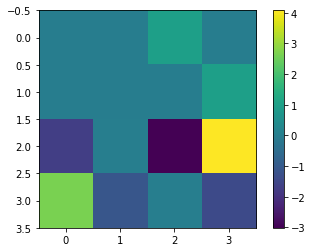

In [3]:
# imshow the jacobian
import matplotlib.pyplot as plt
plt.imshow(J)
plt.colorbar()
plt.show()

In [4]:
np.linalg.eigvals(B)

array([3.03941094, 1.38632449])

In [5]:
np.linalg.eigvals(K)

array([1.81381665, 0.99034976])